In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline, CubicSpline, interp1d
from scipy.optimize import curve_fit
import time
import scipy


from openparticle.hamiltonians.free_hamiltonians import free_boson_Hamiltonian, free_fermion_Hamiltonian
from openparticle.hamiltonians.yukawa_hamiltonians import *
from openparticle.hamiltonians.renormalized_yukawa_hamiltonian import *
from openparticle.utils import *
from openparticle.dlcq import get_sector_basis, pdf, fock_sector_budget
from yukawa_utils import *

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 24
plt.rc('text', usetex=True)
import warnings
warnings.filterwarnings('ignore')

In [6]:
#Universal parameters in all plots:
mf = 1
mb = 0.5

### `Plot #1`: Bare $M^2$ vs. $K$

In [54]:
plot_1_g = 1

eigenvalues_boson_loop = []
eigenvalues_fermion_loop = []
eigenvalues_Q2 = []
resolutions_boson_loop = np.arange(1, 9, 1)
resolutions_fermion_loop = np.arange(1/2, 9, 1)
resolutions_Q2 = np.arange(3, 9, 1)

for res in resolutions_boson_loop:

    basis = impose_baryon_number(int(res), momentum_states_partition(res), 0)
    

    
    hamiltonian = yukawa_hamiltonian(
            res=int(res), g=plot_1_g, mf=mf, mb=mb
        )

    tmp_mat = generate_matrix_hermitian(hamiltonian, basis)
    vals, vecs = np.linalg.eigh(tmp_mat)
    eigenvalues_boson_loop.append(min(vals))

for res in resolutions_fermion_loop:

    basis = impose_baryon_number(int(res + 1/2), momentum_states_partition(res), 1)
    hamiltonian = yukawa_hamiltonian(
            res=int(res + 1/2), g=plot_1_g, mf=mf, mb=mb
        )
    tmp_mat = generate_matrix_hermitian(hamiltonian, basis)
    vals, vecs = np.linalg.eigh(tmp_mat)
    eigenvalues_fermion_loop.append(min(vals))

for res in resolutions_Q2:

    basis = impose_baryon_number(int(res), momentum_states_partition(res), 2)
    

    hamiltonian = yukawa_hamiltonian(
            res=int(res), g=plot_1_g, mf=mf, mb=mb
        )

    tmp_mat = generate_matrix_hermitian(hamiltonian, basis)
    vals, vecs = np.linalg.eigh(tmp_mat)
    eigenvalues_Q2.append(min(vals))
    


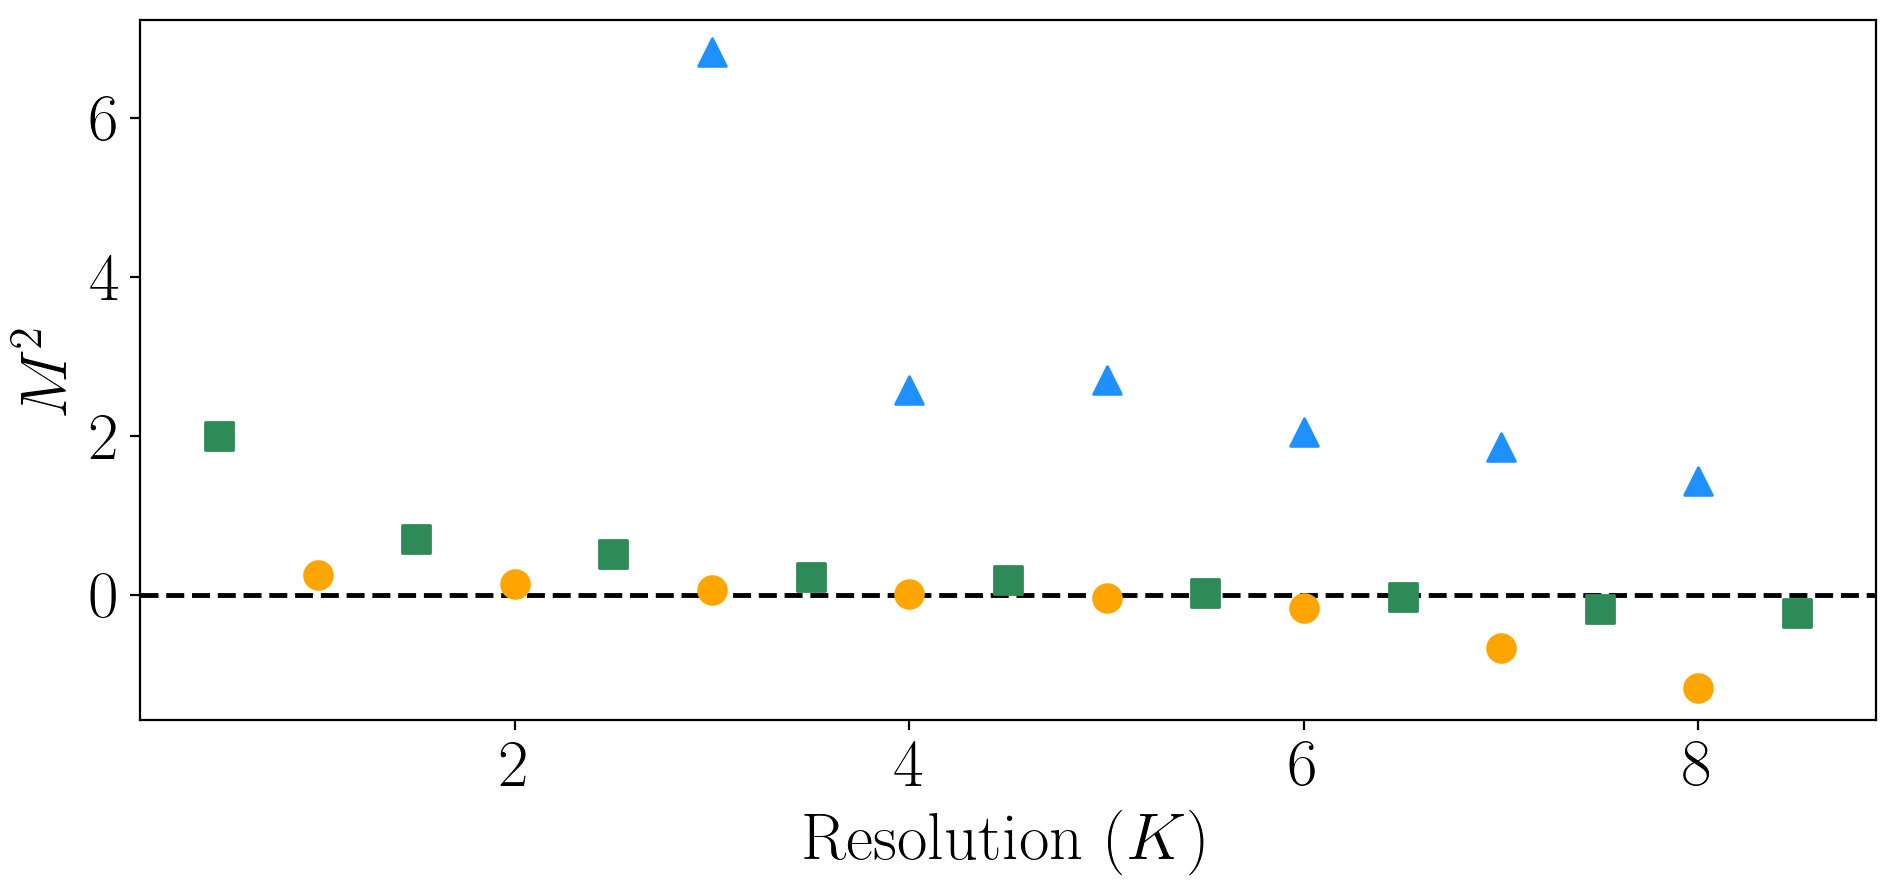

In [55]:
plt.figure(figsize=(10,5), dpi=200)
plt.scatter(resolutions_boson_loop, eigenvalues_boson_loop, color='orange', marker='o', s=100, label = r'$Q = 0$')
plt.scatter(resolutions_fermion_loop, eigenvalues_fermion_loop, color='seagreen', marker='s', s=100, label = r'$Q = 1$')
# plt.scatter(resolutions_Q2, eigenvalues_Q2, color=[(0,0.5,0.5)], marker='^', s=100, label = r'$Q = 2$')
plt.scatter(resolutions_Q2, eigenvalues_Q2, color='dodgerblue', marker='^', s=100, label = r'$Q = 2$')

plt.axhline(y=0, color='k', linewidth = 1.75, zorder = -1, linestyle = '--')

plt.xlabel(r"Resolution $(K)$")
plt.ylabel(r"$M^2$")
# plt.legend()
plt.tight_layout()
plt.savefig('../M2_vs_K_bare.pdf')
# plt.title(r"Lowest $M^2$ Eigenvalue in Respective Sectors")

### `Plot #2:` Yukawa Non-relativistic $E$ vs. $\mu$

In [56]:
plot_2_g_1 = 0.3
plot_2_g_2 = 1

N = 200  # Number of grid points
x_max = 20 # Maximum x value (adjust as needed)
x_min = -20
dx = (x_max-x_min)/N
x = np.linspace(x_min, x_max, N+1)

def create_hamiltonian(V):
  c = 1 ** 2 / ( mf * dx ** 2)
  hamiltonian = np.zeros((N+1, N+1))
  for i in range(1, N - 1):
      hamiltonian[i, i] = 2 * c + V[i]
      hamiltonian[i, i + 1] = -c
      hamiltonian[i, i - 1] = -c
  return hamiltonian

bounds = []
mus = np.arange(0.1, 1, 1e-3)
for mu in mus:
    V = -plot_2_g_1**2 / (2 * mu) * np.exp(-mu * np.abs(x))
    H=create_hamiltonian(V)

    # # Solve for eigenvalues and eigenvectors and sort
    # eigenvalues, eigenvectors = np.linalg.eig(H)
    # bounds.append(eigenvalues[eigenvalues < 0])
    eigenvalues, eigenvectors = np.linalg.eig(H)
    eigenvalues = np.sort(eigenvalues)  # Ensure sorted order
    bounds.append(eigenvalues[eigenvalues < 0])


padded_eigenvalues_plot_2_g1 = np.array(
    [
        np.pad(eig, (0, max(len(eig) for eig in bounds) - len(eig)), constant_values=np.nan)
        for eig in bounds
    ]
)


bounds = []
mus = np.arange(0.1, 1, 1e-3)
for mu in mus:
    V = -plot_2_g_2**2 / (2 * mu) * np.exp(-mu * np.abs(x))
    H=create_hamiltonian(V)

    # # Solve for eigenvalues and eigenvectors and sort
    # eigenvalues, eigenvectors = np.linalg.eig(H)
    # bounds.append(eigenvalues[eigenvalues < 0])
    eigenvalues, eigenvectors = np.linalg.eig(H)
    eigenvalues = np.sort(eigenvalues)  # Ensure sorted order
    bounds.append(eigenvalues[eigenvalues < 0])


padded_eigenvalues_plot_2_g2 = np.array(
    [
        np.pad(eig, (0, max(len(eig) for eig in bounds) - len(eig)), constant_values=np.nan)
        for eig in bounds
    ]
)

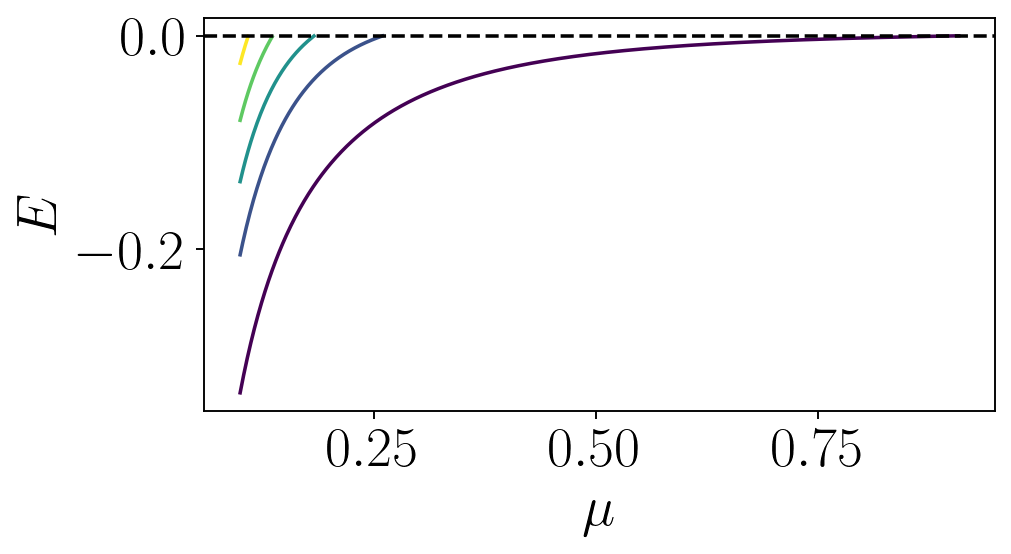

In [383]:
# plt.figure(figsize=(8, 6), dpi=170)
# plt.plot(mus, padded_eigenvalues_plot_2)
# plt.ylabel(f"$E$")
# plt.xlabel(f"$\mu$")
# # plt.title(f"1D Yukawa Eigenvalues at $g = {plot_2_g}$")
# plt.axhline(y = 0, linestyle = '--', color = 'k')
# # plt.ylim(-1, 0.1)
# # plt.xscale('log')
# plt.show()
plt.figure(figsize=(6,3), dpi=170)

# Define colormap
num_curves = padded_eigenvalues_plot_2_g1.shape[1]  # Number of eigenvalue curves
cmap = plt.cm.get_cmap("viridis", num_curves)  # Get the Viridis colormap

# Plot each eigenvalue trajectory with a unique color
for i in range(num_curves):
    plt.plot(mus, padded_eigenvalues_plot_2_g1[:, i], color=cmap(i / num_curves))

# Labels and styling
plt.ylabel(f"$E$")
plt.xlabel(f"$\mu$")
plt.axhline(y=0, linestyle='--', color='k')  # Zero energy reference

plt.show()

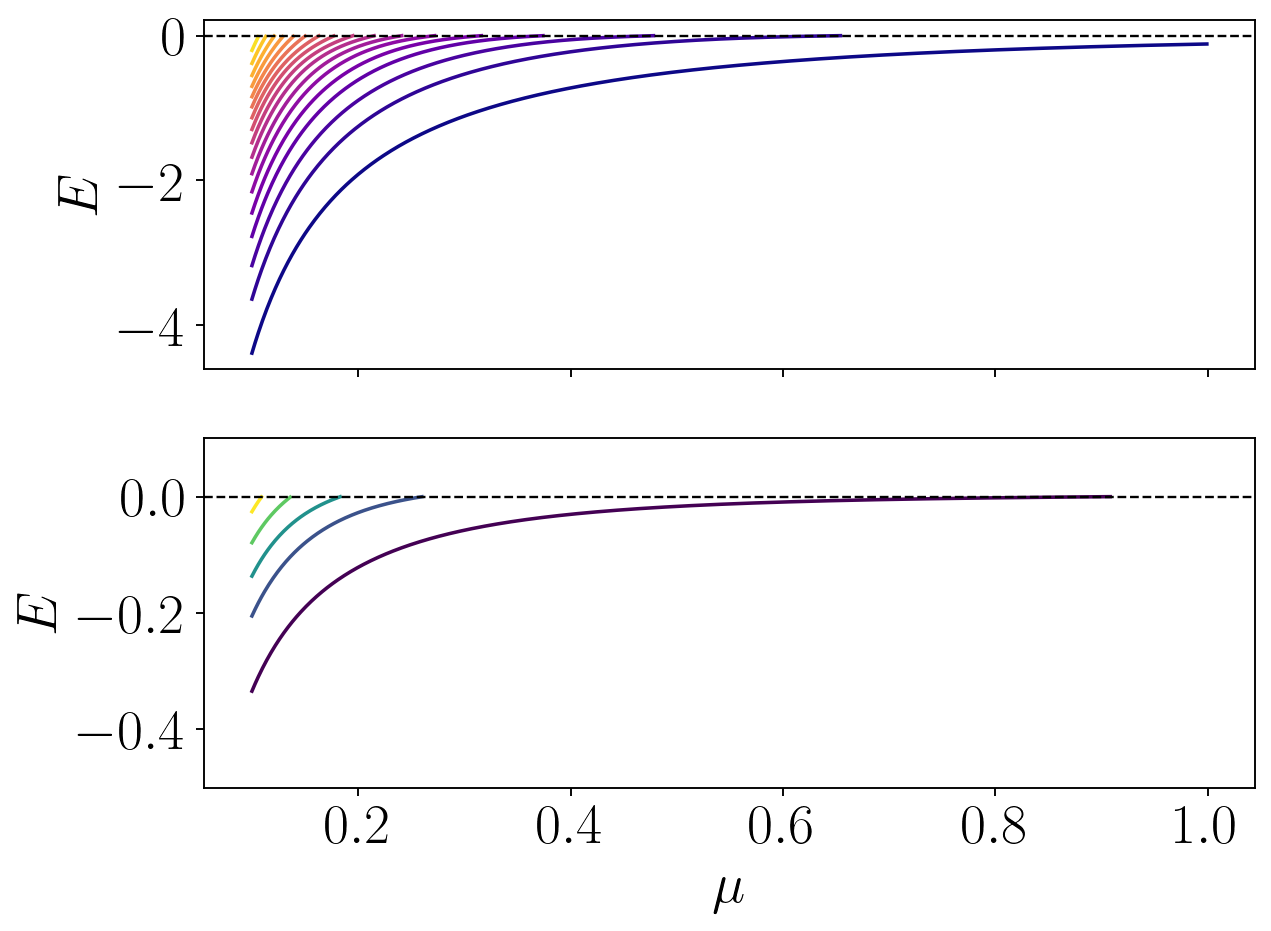

In [61]:
padded_eigenvalues_1 = padded_eigenvalues_plot_2_g1  # First dataset
padded_eigenvalues_2 = padded_eigenvalues_plot_2_g2  # Second dataset

# Get the number of curves in each dataset
num_curves_1 = padded_eigenvalues_1.shape[1]
num_curves_2 = padded_eigenvalues_2.shape[1]

# Create figure with vertically stacked subplots, ensuring width > height
fig, axs = plt.subplots(2, 1, figsize=(8, 6), dpi=170, sharex=True)

# Define colormaps for both sets
cmap1 = plt.cm.get_cmap("viridis", num_curves_1)
cmap2 = plt.cm.get_cmap("plasma", num_curves_2)



# Plot first dataset
for i in range(num_curves_2):
    axs[0].plot(mus, padded_eigenvalues_2[:, i], color=cmap2(i / max(1, num_curves_2 - 1)))
axs[0].axhline(y=0, linestyle='--', color='k', linewidth=1)
axs[0].set_ylabel(f"$E$")


# Plot second dataset
for i in range(num_curves_1):
    axs[1].plot(mus, padded_eigenvalues_1[:, i], color=cmap1(i / max(1, num_curves_1 - 1)))
axs[1].axhline(y=0, linestyle='--', color='k', linewidth=1)
axs[1].set_ylabel(f"$E$")
axs[1].set_xlabel(f"$\mu$")
axs[1].set_ylim(-0.5, 0.1)

# Ensure limits are the same for comparison (optional)
# y_min = min(np.nanmin(padded_eigenvalues_1), np.nanmin(padded_eigenvalues_2))
# y_max = max(np.nanmax(padded_eigenvalues_1), np.nanmax(padded_eigenvalues_2))
# axs[0].set_ylim(y_min, y_max)
# axs[1].set_ylim(y_min, y_max)

# Adjust layout for better spacing
plt.tight_layout()
plt.savefig('../non-rel.pdf')

### `Plot #3`: Renormalized $M^2$ vs. $K$ for sectors $\{|f\rangle, |fb\rangle \}$ and $\{|ff\rangle, |ffb\rangle \}$ at $g \in \{0.3, 1, 3 \}$

In [40]:
plot_3_t = 1e-12

$g = 0.3$

In [41]:
max_K = 20

plot_3_g_1 = 0.3

eigenvalues_f_fb_basis_g03 = []
eigenvalues_ff_ffb_basis_g03 = []

f_fb_resolutions = np.arange(1/2, max_K, 2)
ff_ffb_resolutions = np.arange(2, max_K + 1, 2)

for res in f_fb_resolutions:

    f_fb_basis = (
        get_sector_basis(resolution = res, n_fermions = 1, n_antifermions = 0, n_bosons = 0)
        + get_sector_basis(resolution = res, n_fermions = 1, n_antifermions = 0, n_bosons = 1)
    )  

    hamiltonian = renormalized_yukawa_hamiltonian(
            res=res, t=plot_3_t, treg=0, g=plot_3_g_1, mf=mf, mb=mb, verbose=False
        )

    tmp_mat = generate_matrix_hermitian(hamiltonian, f_fb_basis)
    vals, vecs = np.linalg.eigh(tmp_mat)
    eigenvalues_f_fb_basis_g03.append(min(vals))

for res in ff_ffb_resolutions:

    ff_ffb_basis = (
        get_sector_basis(resolution = res, n_fermions = 2, n_antifermions = 0, n_bosons = 0)
        + get_sector_basis(resolution = res, n_fermions = 2, n_antifermions = 0, n_bosons = 1)
    )  

    hamiltonian = renormalized_yukawa_hamiltonian(
            res=res, t=plot_3_t, treg=0, g=plot_3_g_1, mf=mf, mb=mb, verbose=False
        )
    
    tmp_mat = generate_matrix_hermitian(hamiltonian, ff_ffb_basis)
    vals, vecs = np.linalg.eigh(tmp_mat)
    eigenvalues_ff_ffb_basis_g03.append(min(vals))

In [5]:
def t(Lambda):
    return 1/(Lambda**4)

def _lambda(t):
    return t**(-1/4)

Text(0, 0.5, '$M^2$')

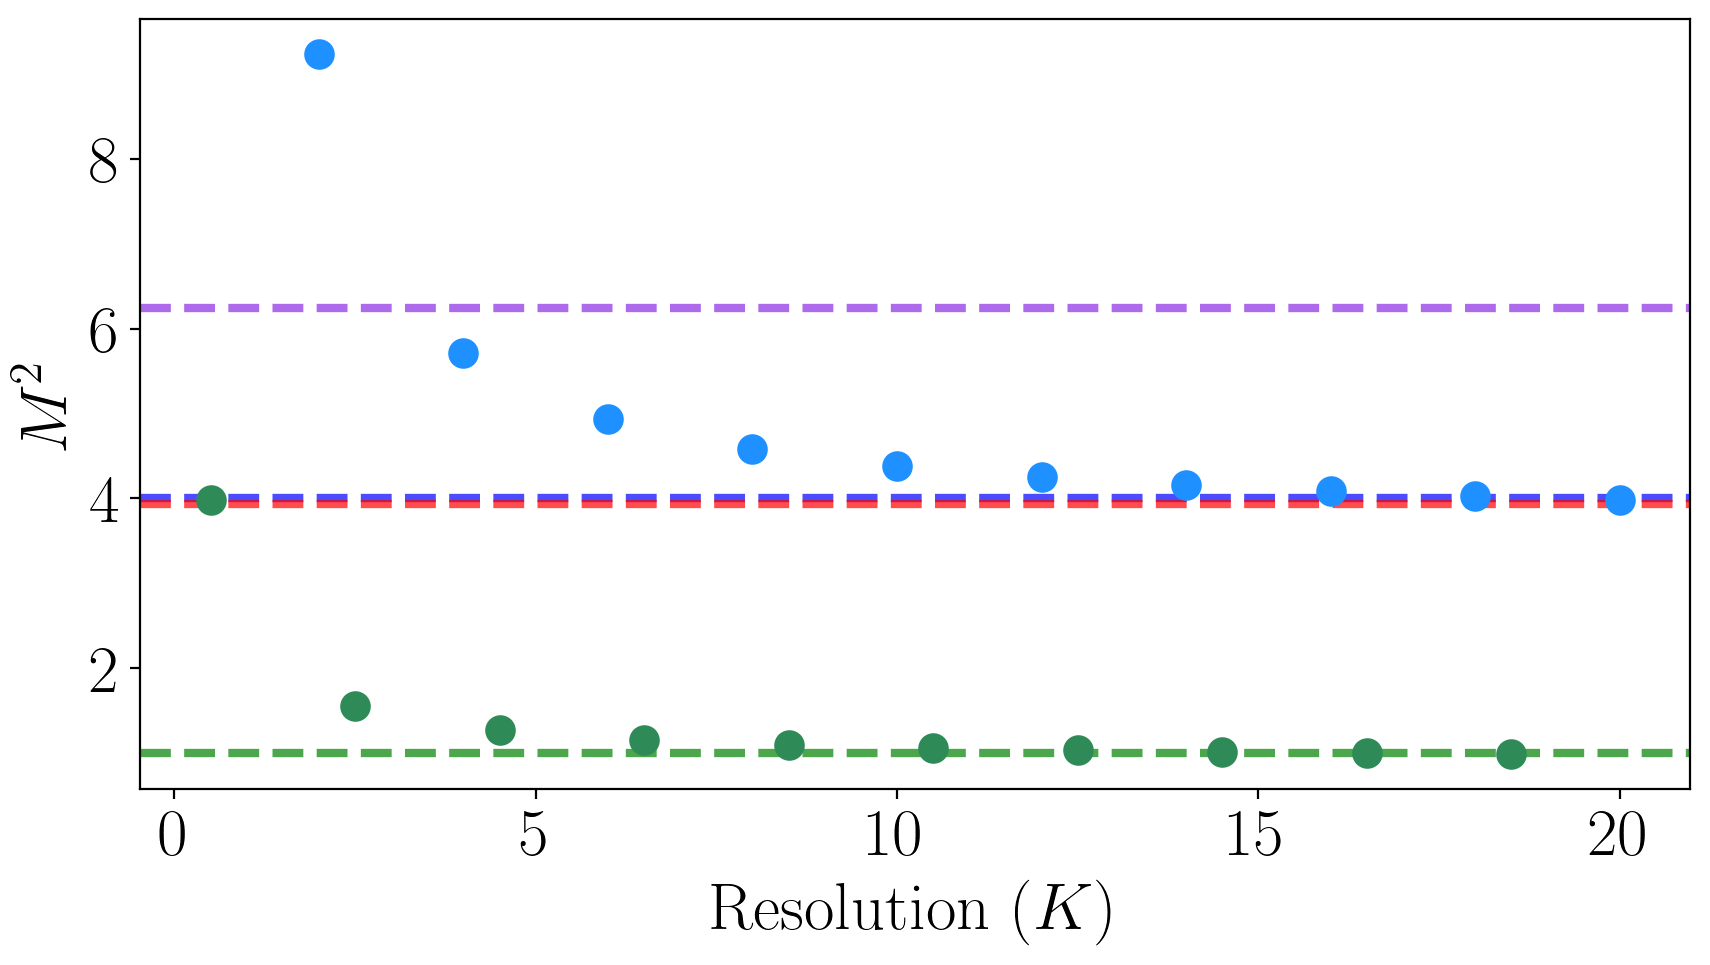

In [317]:
plt.figure(figsize=(10,5), dpi=200)

plt.scatter(f_fb_resolutions, eigenvalues_f_fb_basis_g03, marker = 'o', color = 'seagreen', s = 100)
plt.scatter(ff_ffb_resolutions, eigenvalues_ff_ffb_basis_g03, marker = 'o', color = 'dodgerblue', s = 100)

plt.axhline(y=mf**2, color='green', alpha = 0.7, linestyle = '--', linewidth = 3, zorder = -1)
plt.axhline(y=(2*mf)**2, color='blue', alpha = 0.7,linestyle = '--', linewidth = 3, zorder = -1)
plt.axhline(y=(2*mf + mb)**2, color='blueviolet', alpha = 0.7, linestyle = '--', linewidth = 3)
plt.axhline(y=min(nonrelativistic_yukawa(plot_3_g_1, mf, mb)) * 2*2*mf + (2*mf)**2, color='r', alpha = 0.7,linestyle = '--', linewidth = 3, zorder = -1)

plt.xlabel(r"Resolution $(K)$")
plt.ylabel(r"$M^2$")
# plt.title(f'$g = {plot_3_g_1}$')
# plt.title(r"Lowest $M^2$ Eigenvalue in Two Sectors") 
# plt.text(15, 8, f'$g = {plot_3_g_1}$', fontsize=29)
# plt.text(17, 7, f'$t = {1/(plot_3_t**2)}$', fontsize=29)
# plt.text(15, 7, f'$\lambda = {_lambda(plot_3_t)}$', fontsize=29)



In [42]:
def m2_fit(x, a, b, c):
    return a + b/x + c/(x**2)

g03_fit_params_f_fb = curve_fit(m2_fit, f_fb_resolutions[1:], eigenvalues_f_fb_basis_g03[1:])
g03_fit_params_ff_ffb = curve_fit(m2_fit, ff_ffb_resolutions[1:], eigenvalues_ff_ffb_basis_g03[1:])

In [45]:
y_f_fb, y_ff_ffb

(0.8956310463537749, 3.62839505669864)

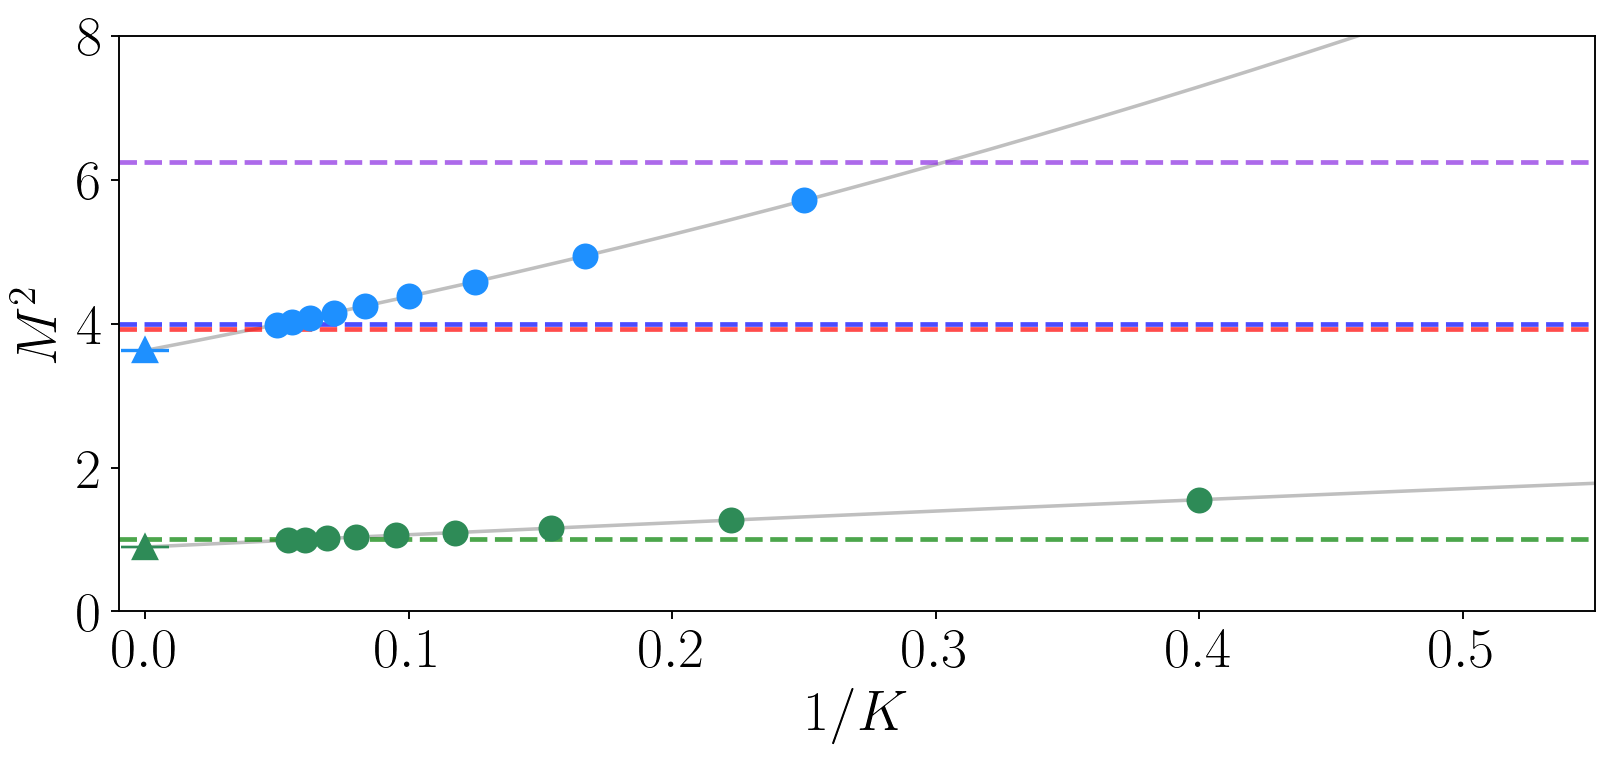

In [53]:
plt.figure(figsize=(10,5), dpi=170)

ks = np.arange(0, 2, 0.01)

plt.scatter(1/f_fb_resolutions[1:], eigenvalues_f_fb_basis_g03[1:], marker = 'o', color = 'seagreen', s = 100)
plt.plot(ks, m2_fit(1/ks, *g03_fit_params_f_fb[0]), alpha = 0.5, color = 'grey', zorder = -1)
plt.scatter(1/ff_ffb_resolutions[1:], eigenvalues_ff_ffb_basis_g03[1:], marker = 'o', color = 'dodgerblue', s = 100)
plt.plot(ks, m2_fit(1/ks, *g03_fit_params_ff_ffb[0]), alpha = 0.5, color = 'grey', zorder = -1)

plt.axhline(y=mf**2, color='green', alpha = 0.7, linestyle = '--', linewidth = 2, zorder = -1)
plt.axhline(y=(2*mf)**2, color='blue', alpha = 0.7,linestyle = '--', linewidth = 2, zorder = -1)
plt.axhline(y=(2*mf + mb)**2, color='blueviolet', alpha = 0.7, linestyle = '--', linewidth = 2, zorder = -1)
plt.axhline(y=min(nonrelativistic_yukawa(plot_3_g_1, mf, mb)) * 2*2*mf + (2*mf)**2, color='r', alpha = 0.7,linestyle = '--', linewidth = 2, zorder = -1)


x = 0
y_f_fb = m2_fit(np.inf, *g03_fit_params_f_fb[0])
y_f_fb_err = np.sqrt(np.diag(g03_fit_params_f_fb[1]))[0]

y_ff_ffb = m2_fit(np.inf, *g03_fit_params_ff_ffb[0])
y_ff_ffb_bare = np.sqrt(np.diag(g03_fit_params_ff_ffb[1]))[0]

plt.errorbar(x, y_f_fb, yerr=y_f_fb_err, fmt='^', color = 'seagreen', capsize=10, label=f"{y_f_fb.round(3)}", ms = 10)
plt.errorbar(x, y_ff_ffb, yerr=y_ff_ffb_bare, fmt='^', color = 'dodgerblue', capsize=10, label=f"{y_ff_ffb.round(3)}", ms = 10)


plt.xlim(-0.01, 0.55)
plt.ylim(-0, 8)
plt.xlabel(r"$1/K$")
plt.ylabel(r"$M^2$")



# plt.title(f'$g = {plot_3_g_1}$')
# plt.title(r"Lowest $M^2$ Eigenvalue in Two Sectors")
# plt.text(17, 8, f'$g = {plot_3_g_1}$', fontsize=29)
# plt.text(17, 7, f'$t = {1/(plot_3_t**2)}$', fontsize=29)
# plt.text(17, 7, r'$\lambda = 10^{22}$', fontsize=29)
plt.tight_layout()
plt.savefig('../M2_vs_K_g03.pdf')

$g = 1.0$

In [47]:
max_K = 20

plot_3_g_2 = 1

eigenvalues_f_fb_basis_g1 = []
eigenvalues_ff_ffb_basis_g1 = []

f_fb_resolutions = np.arange(1/2, max_K, 2)
ff_ffb_resolutions = np.arange(2, max_K + 1, 2)

for res in f_fb_resolutions:

    f_fb_basis = (
        get_sector_basis(resolution = res, n_fermions = 1, n_antifermions = 0, n_bosons = 0)
        + get_sector_basis(resolution = res, n_fermions = 1, n_antifermions = 0, n_bosons = 1)
    )  

    hamiltonian = renormalized_yukawa_hamiltonian(
            res=res, t=plot_3_t, treg=0, g=plot_3_g_2, mf=mf, mb=mb, verbose=False
        )

    tmp_mat = generate_matrix_hermitian(hamiltonian, f_fb_basis)
    vals, vecs = np.linalg.eigh(tmp_mat)
    eigenvalues_f_fb_basis_g1.append(min(vals))

for res in ff_ffb_resolutions:

    ff_ffb_basis = (
        get_sector_basis(resolution = res, n_fermions = 2, n_antifermions = 0, n_bosons = 0)
        + get_sector_basis(resolution = res, n_fermions = 2, n_antifermions = 0, n_bosons = 1)
    )  

    hamiltonian = renormalized_yukawa_hamiltonian(
            res=res, t=plot_3_t, treg=0, g=plot_3_g_2, mf=mf, mb=mb, verbose=False
        )
    
    tmp_mat = generate_matrix_hermitian(hamiltonian, ff_ffb_basis)
    vals, vecs = np.linalg.eigh(tmp_mat)
    eigenvalues_ff_ffb_basis_g1.append(min(vals))

(0.0, 40.0)

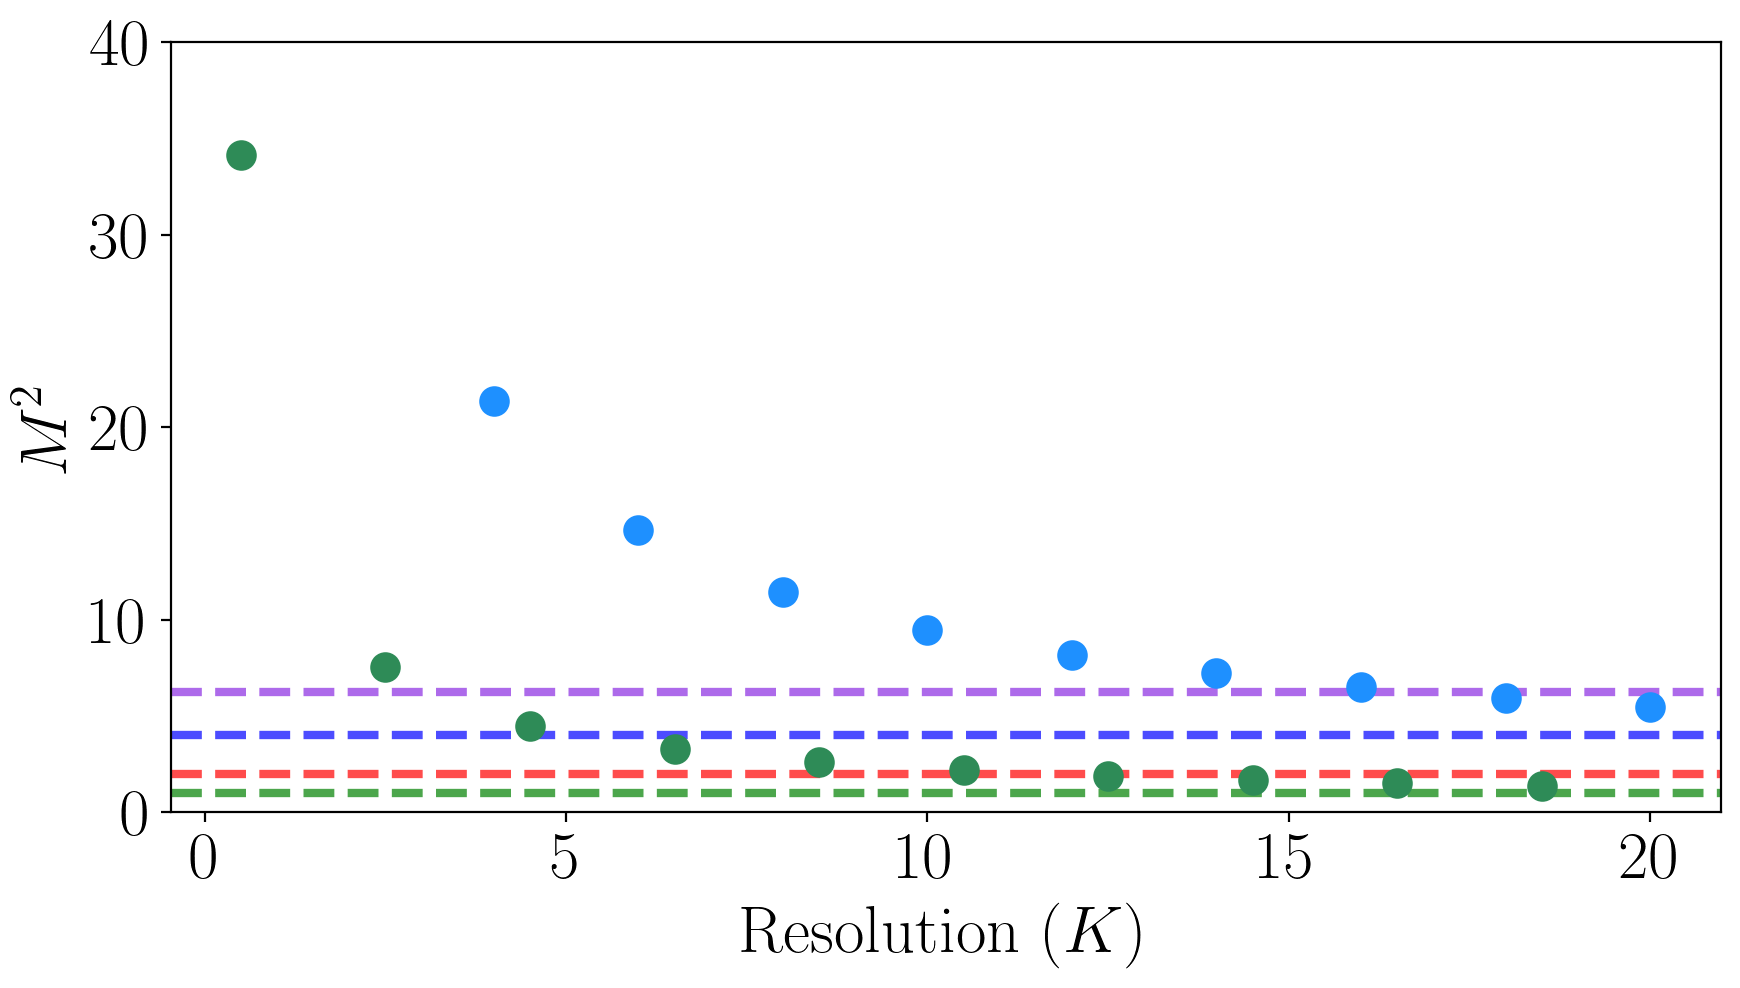

In [334]:
plt.figure(figsize=(10,5), dpi=200)

plt.scatter(f_fb_resolutions, eigenvalues_f_fb_basis_g1, marker = 'o', color = 'seagreen', s = 100)
plt.scatter(ff_ffb_resolutions, eigenvalues_ff_ffb_basis_g1, marker = 'o', color = 'dodgerblue', s = 100)

plt.axhline(y=mf**2, color='green', alpha = 0.7, linestyle = '--', linewidth = 3, zorder = -1)
plt.axhline(y=(2*mf)**2, color='blue', alpha = 0.7,linestyle = '--', linewidth = 3, zorder = -1)
plt.axhline(y=(2*mf + mb)**2, color='blueviolet', alpha = 0.7, linestyle = '--', linewidth = 3, zorder = -1)
plt.axhline(y=min(nonrelativistic_yukawa(plot_3_g_2, mf, mb)) * 2*2*mf + (2*mf)**2, color='r', alpha = 0.7,linestyle = '--', linewidth = 3, zorder = -1)

plt.xlabel(r"Resolution $(K)$")
plt.ylabel(r"$M^2$")
plt.ylim(0, 40)
# plt.ylim(0, 10)
# plt.title(f'$g = {plot_3_g_1}$')
# plt.title(r"Lowest $M^2$ Eigenvalue in Two Sectors") 
# plt.text(15, 8, f'$g = {plot_3_g_1}$', fontsize=29)
# plt.text(17, 7, f'$t = {1/(plot_3_t**2)}$', fontsize=29)
# plt.text(15, 7, f'$\lambda = {_lambda(plot_3_t)}$', fontsize=29)



In [48]:
def m2_fit(x, a, b, c):
    return a + b/x + c/(x**2)

g1_fit_params_f_fb = curve_fit(m2_fit, f_fb_resolutions[1:], eigenvalues_f_fb_basis_g1[1:])
g1_fit_params_ff_ffb = curve_fit(m2_fit, ff_ffb_resolutions[1:], eigenvalues_ff_ffb_basis_g1[1:])

In [50]:
y_f_fb, y_ff_ffb

(0.3304002781907888, 1.6161826613787704)

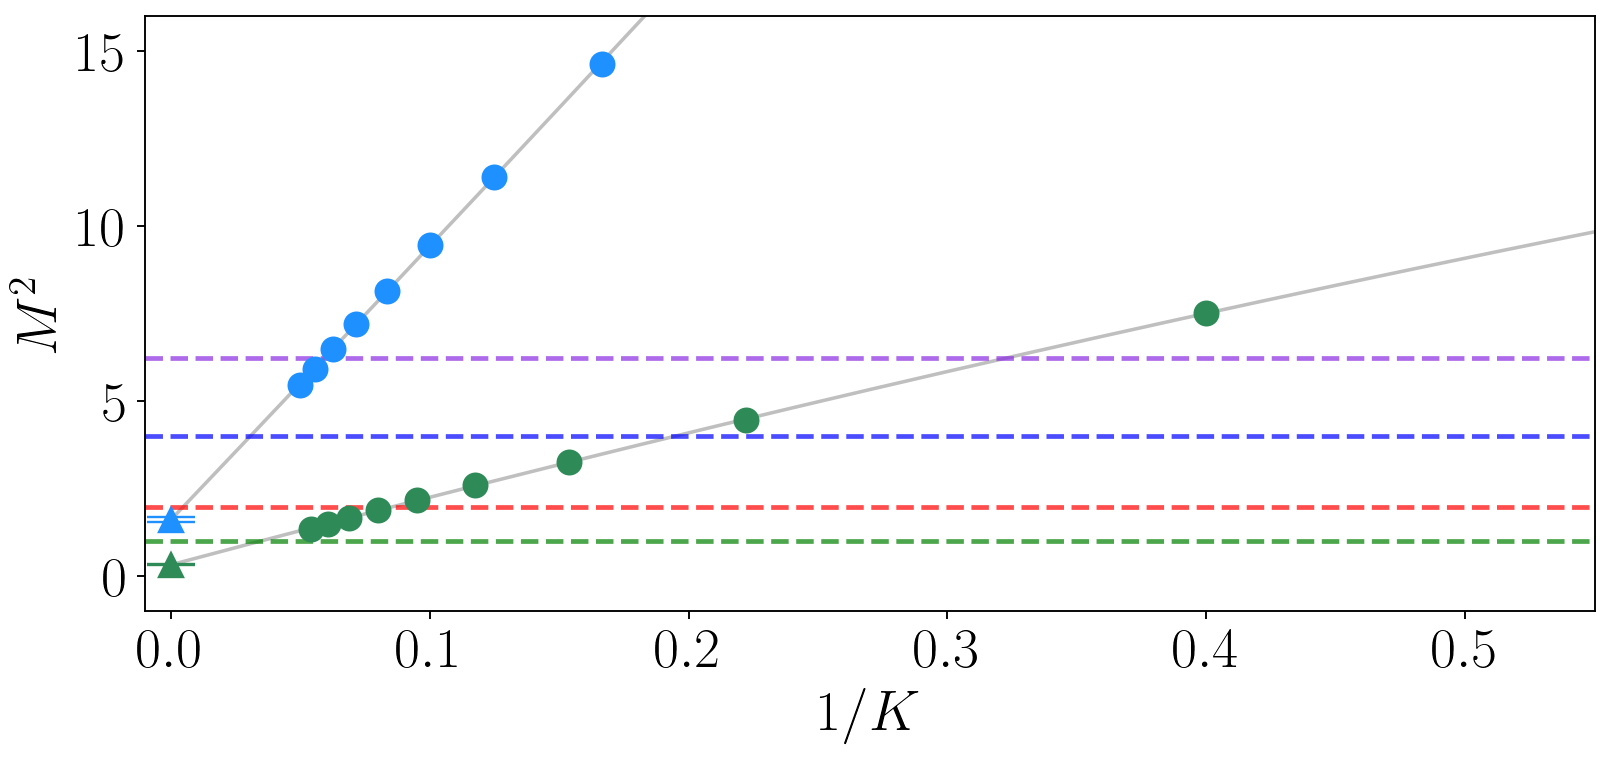

In [52]:
plt.figure(figsize=(10,5), dpi=170)

ks = np.arange(0, 2, 0.01)

plt.scatter(1/f_fb_resolutions[1:], eigenvalues_f_fb_basis_g1[1:], marker = 'o', color = 'seagreen', s = 100)
plt.plot(ks, m2_fit(1/ks, *g1_fit_params_f_fb[0]), alpha = 0.5, color = 'grey', zorder = -1)
plt.scatter(1/ff_ffb_resolutions[1:], eigenvalues_ff_ffb_basis_g1[1:], marker = 'o', color = 'dodgerblue', s = 100)
plt.plot(ks, m2_fit(1/ks, *g1_fit_params_ff_ffb[0]), alpha = 0.5, color = 'grey', zorder = -1)

plt.axhline(y=mf**2, color='green', alpha = 0.7, linestyle = '--', linewidth = 2, zorder = -1)
plt.axhline(y=(2*mf)**2, color='blue', alpha = 0.7,linestyle = '--', linewidth = 2, zorder = -1)
plt.axhline(y=(2*mf + mb)**2, color='blueviolet', alpha = 0.7, linestyle = '--', linewidth = 2, zorder = -1)
plt.axhline(y=min(nonrelativistic_yukawa(plot_3_g_2, mf, mb)) * 2*2*mf + (2*mf)**2, color='r', alpha = 0.7,linestyle = '--', linewidth = 2, zorder = -1)


x = 0
y_f_fb = m2_fit(np.inf, *g1_fit_params_f_fb[0])
y_f_fb_err = np.sqrt(np.diag(g1_fit_params_f_fb[1]))[0]

y_ff_ffb = m2_fit(np.inf, *g1_fit_params_ff_ffb[0])
y_ff_ffb_bare = np.sqrt(np.diag(g1_fit_params_ff_ffb[1]))[0]

plt.errorbar(x, y_f_fb, yerr=y_f_fb_err, fmt='^', color = 'seagreen', capsize=10, label=f"{y_f_fb.round(3)}", ms = 10)
plt.errorbar(x, y_ff_ffb, yerr=y_ff_ffb_bare, fmt='^', color = 'dodgerblue', capsize=10, label=f"{y_ff_ffb.round(3)}", ms = 10)


plt.xlim(-0.01, 0.55)
plt.ylim(-1, 16)
plt.xlabel(r"$1/K$")
plt.ylabel(r"$M^2$")
plt.tight_layout()
plt.savefig('../M2_vs_K_g1.pdf')


$g = 3$

In [278]:
max_K = 20

plot_3_g_3 = 3

eigenvalues_f_fb_basis_g3 = []
eigenvalues_ff_ffb_basis_g3 = []

f_fb_resolutions = np.arange(1/2, max_K, 2)
ff_ffb_resolutions = np.arange(2, max_K + 1, 2)

for res in f_fb_resolutions:

    f_fb_basis = (
        get_sector_basis(resolution = res, n_fermions = 1, n_antifermions = 0, n_bosons = 0)
        + get_sector_basis(resolution = res, n_fermions = 1, n_antifermions = 0, n_bosons = 1)
    )  

    hamiltonian = renormalized_yukawa_hamiltonian(
            res=res, t=plot_3_t, treg=0, g=plot_3_g_3, mf=mf, mb=mb, verbose=False
        )

    tmp_mat = generate_matrix_hermitian(hamiltonian, f_fb_basis)
    vals, vecs = np.linalg.eigh(tmp_mat)
    eigenvalues_f_fb_basis_g3.append(min(vals))

for res in ff_ffb_resolutions:

    ff_ffb_basis = (
        get_sector_basis(resolution = res, n_fermions = 2, n_antifermions = 0, n_bosons = 0)
        + get_sector_basis(resolution = res, n_fermions = 2, n_antifermions = 0, n_bosons = 1)
    )  

    hamiltonian = renormalized_yukawa_hamiltonian(
            res=res, t=plot_3_t, treg=0, g=plot_3_g_3, mf=mf, mb=mb, verbose=False
        )
    
    tmp_mat = generate_matrix_hermitian(hamiltonian, ff_ffb_basis)
    vals, vecs = np.linalg.eigh(tmp_mat)
    eigenvalues_ff_ffb_basis_g3.append(min(vals))

Text(0, 0.5, '$M^2$')

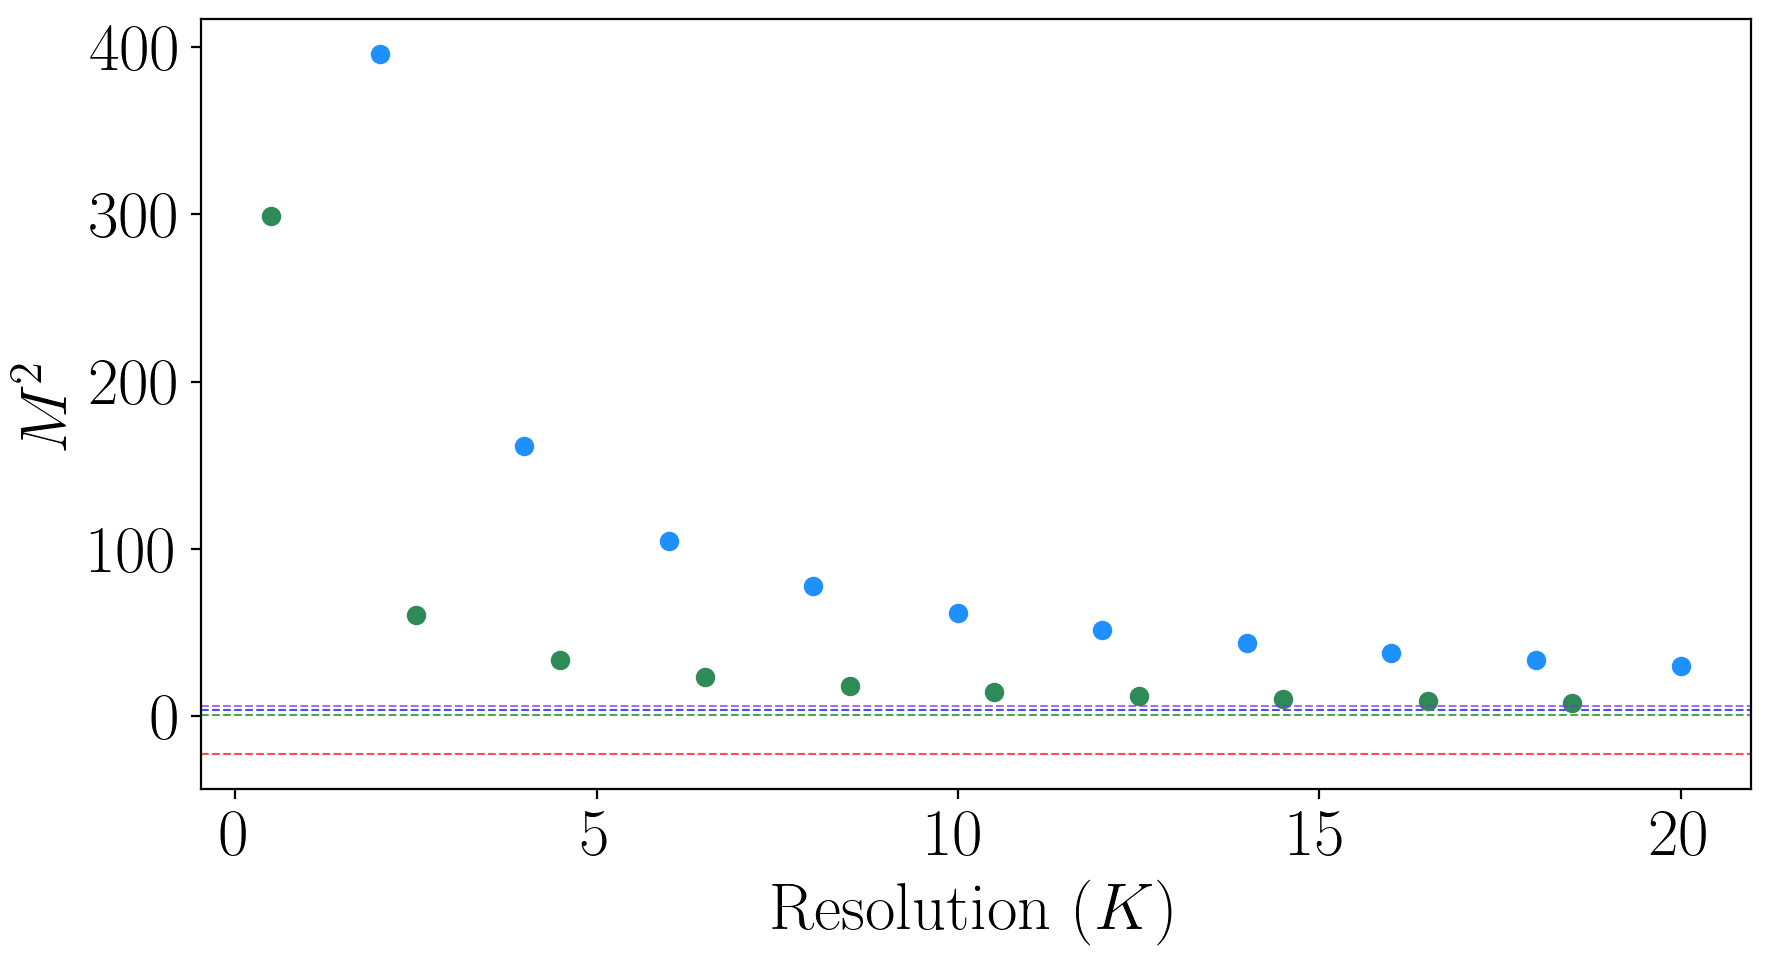

In [279]:
plt.figure(figsize=(10,5), dpi=200)

plt.scatter(f_fb_resolutions, eigenvalues_f_fb_basis_g3, marker = 'o', color = 'seagreen')
plt.scatter(ff_ffb_resolutions, eigenvalues_ff_ffb_basis_g3, marker = 'o', color = 'dodgerblue')

plt.axhline(y=mf**2, color='green', alpha = 0.7, linestyle = '--', linewidth = 0.75, zorder = -1)
plt.axhline(y=(2*mf)**2, color='blue', alpha = 0.7,linestyle = '--', linewidth = 0.75, zorder = -1)
plt.axhline(y=(2*mf + mb)**2, color='blueviolet', alpha = 0.7, linestyle = '--', linewidth = 0.75)
plt.axhline(y=min(nonrelativistic_yukawa(plot_3_g_3, mf, mb)) * 2*2*mf + (2*mf)**2, color='r', alpha = 0.7,linestyle = '--', linewidth = 0.75, zorder = -1)

plt.xlabel(r"Resolution $(K)$")
plt.ylabel(r"$M^2$")
# plt.ylim(0, 10)
# plt.title(f'$g = {plot_3_g_1}$')
# plt.title(r"Lowest $M^2$ Eigenvalue in Two Sectors") 
# plt.text(15, 8, f'$g = {plot_3_g_1}$', fontsize=29)
# plt.text(17, 7, f'$t = {1/(plot_3_t**2)}$', fontsize=29)
# plt.text(15, 7, f'$\lambda = {_lambda(plot_3_t)}$', fontsize=29)



In [280]:
def m2_fit(x, a, b, c):
    return a + b/x + c/(x**2)

g3_fit_params_f_fb = curve_fit(m2_fit, f_fb_resolutions, eigenvalues_f_fb_basis_g3)
g3_fit_params_ff_ffb = curve_fit(m2_fit, ff_ffb_resolutions, eigenvalues_ff_ffb_basis_g3)

Text(0, 0.5, '$M^2$')

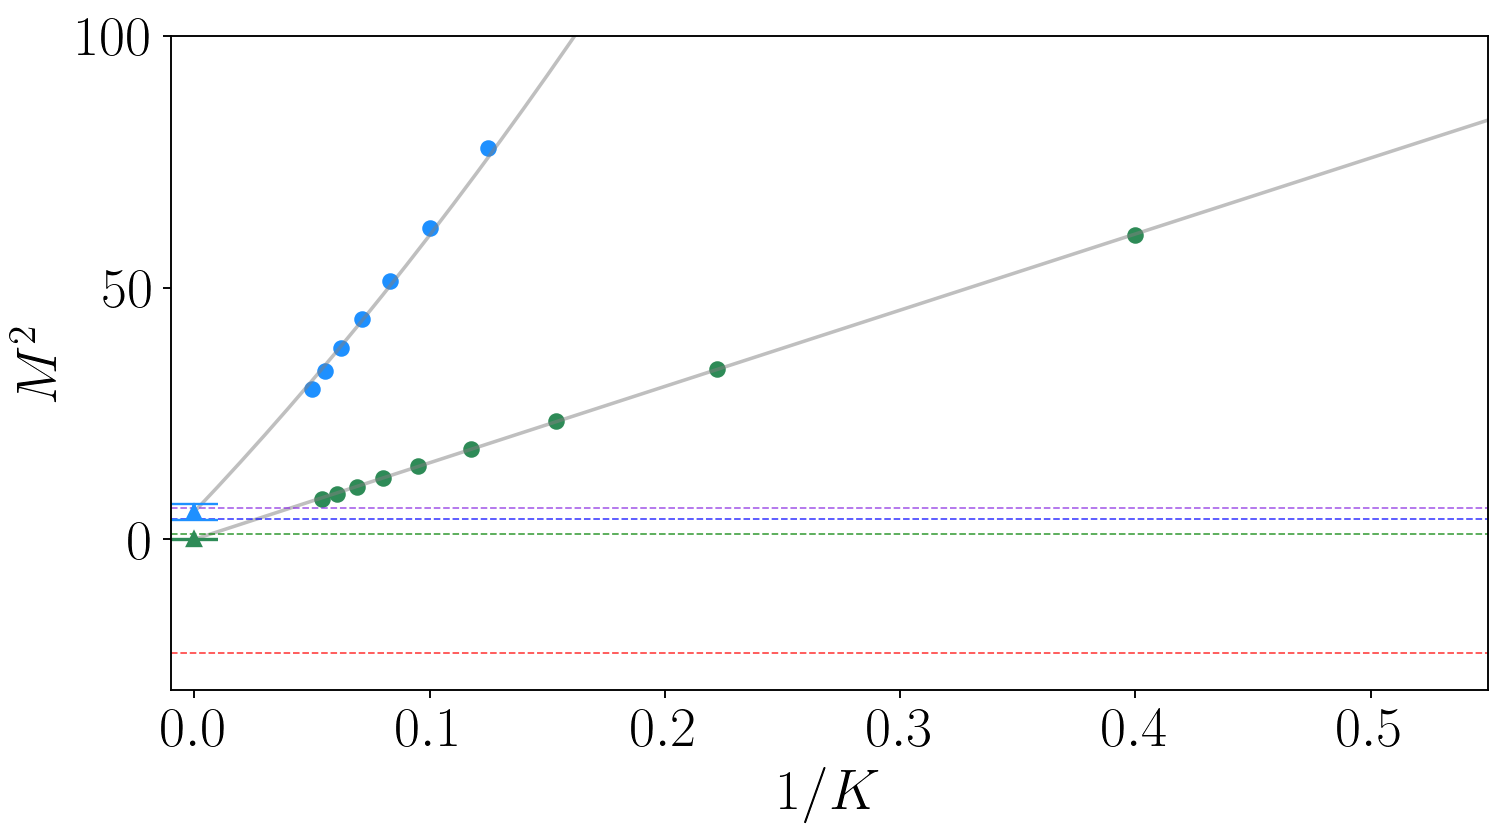

In [289]:
plt.figure(figsize=(10,5), dpi=170)

ks = np.arange(0, 2, 0.01)

plt.scatter(1/f_fb_resolutions, eigenvalues_f_fb_basis_g3, marker = 'o', color = 'seagreen')
plt.plot(ks, m2_fit(1/ks, *g3_fit_params_f_fb[0]), alpha = 0.5, color = 'grey')
plt.scatter(1/ff_ffb_resolutions, eigenvalues_ff_ffb_basis_g3, marker = 'o', color = 'dodgerblue')
plt.plot(ks, m2_fit(1/ks, *g3_fit_params_ff_ffb[0]), alpha = 0.5, color = 'grey')

plt.axhline(y=mf**2, color='green', alpha = 0.7, linestyle = '--', linewidth = 0.75)
plt.axhline(y=(2*mf)**2, color='blue', alpha = 0.7,linestyle = '--', linewidth = 0.75)
plt.axhline(y=(2*mf + mb)**2, color='blueviolet', alpha = 0.7, linestyle = '--', linewidth = 0.75)
plt.axhline(y=min(nonrelativistic_yukawa(plot_3_g_3, mf, mb)) * 2*2*mf + (2*mf)**2, color='r', alpha = 0.7,linestyle = '--', linewidth = 0.75)


x = 0
y_f_fb_g3 = m2_fit(np.inf, *g3_fit_params_f_fb[0])
y_f_fb_err_g3 = np.sqrt(np.diag(g3_fit_params_f_fb[1]))[0]

y_ff_ffb_g3 = m2_fit(np.inf, *g3_fit_params_ff_ffb[0])
y_ff_ffb_err_g3 = np.sqrt(np.diag(g3_fit_params_ff_ffb[1]))[0]

plt.errorbar(x, y_f_fb_g3, yerr=y_f_fb_err_g3, fmt='^', color = 'seagreen', capsize=10, label=f"{y_f_fb.round(3)}")
plt.errorbar(x, y_ff_ffb_g3, yerr=y_ff_ffb_err_g3, fmt='^', color = 'dodgerblue', capsize=10, label=f"{y_ff_ffb.round(3)}")

plt.xlim(-0.01, 0.55)
plt.ylim(-30, 100)
plt.xlabel(r"$1/K$")
plt.ylabel(r"$M^2$")



# plt.title(f'$g = {plot_3_g_1}$')
# plt.title(r"Lowest $M^2$ Eigenvalue in Two Sectors")
# plt.text(17, 8, f'$g = {plot_3_g_1}$', fontsize=29)
# plt.text(17, 7, f'$t = {1/(plot_3_t**2)}$', fontsize=29)
# plt.text(17, 7, r'$\lambda = 10^{22}$', fontsize=29)



### `Plot #5`: Structure Function of $\{|ff\rangle, |ffb\rangle \}$ at $g = 1$

In [18]:
plot_4_res = 34

plot_4_g = 1
plot_4_t = 1e-12

ff_ffb_resolutions = np.arange(2, plot_4_res + 1, 2)


ff_ffb_basis = (
    get_sector_basis(resolution = plot_4_res, n_fermions = 2, n_antifermions = 0, n_bosons = 0)
    + get_sector_basis(resolution = plot_4_res, n_fermions = 2, n_antifermions = 0, n_bosons = 1)
)  

hamiltonian = renormalized_yukawa_hamiltonian(
        res=plot_4_res, t=plot_4_t, treg=0, g=plot_4_g, mf=mf, mb=mb, verbose=False
    )

tmp_mat = generate_matrix_hermitian(hamiltonian, ff_ffb_basis)
vals, vecs = np.linalg.eigh(tmp_mat)

In [19]:
eigenstate = 0

psi = numpy_to_fock(vecs[:, eigenstate], ff_ffb_basis)

fermion_pdf = pdf(plot_4_res, psi, 'fermion')
boson_pdf = pdf(plot_4_res, psi, 'boson')


In [20]:
x_fermion = np.array([k/plot_4_res for k in np.arange(1/2, plot_4_res, 1)])
x_boson = np.array([k/plot_4_res for k in np.arange(1, plot_4_res + 1, 1)])

In [21]:
from scipy.interpolate import PchipInterpolator

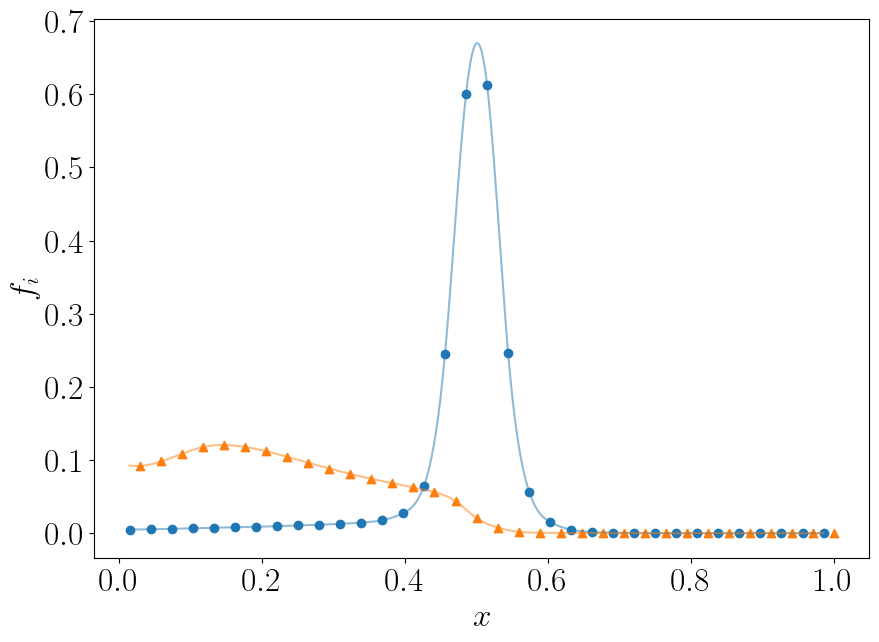

In [26]:
xnew = np.arange(min(x_fermion), max(x_fermion), 0.001)

plt.figure(figsize = (10, 7), dpi = 100)

fermion_interp = CubicSpline(x_fermion, fermion_pdf)
boson_interp = CubicSpline(x_boson, boson_pdf)

plt.scatter(x_fermion, np.real(fermion_pdf), label = f'Fermion')
plt.plot(xnew, fermion_interp(xnew), alpha = 0.5)

plt.scatter(x_boson,10*np.real(boson_pdf),   label = r'$10 \times $Boson', marker = '^')
plt.plot(xnew, 10*boson_interp(xnew), alpha = 0.5)
# plt.legend()
plt.xlabel(f'$x$')
plt.ylabel(f'$f_i$')
# plt.ylim(-0.1, 1)
# plt.yscale('log')
# plt.title(f"$ff$ bound state Structure Function")
plt.savefig('../sf.pdf')

### `Plot #5`: $m^2$ vs. $g$ extrapolation at $K_{max} = 20$, $t = 1e-12$

In [200]:
mf = 1
mb = 0.5
t = 1e-12

def l(x, a, b, c):
    return a + b/x + c/(x**2)



f_fb_basis = np.arange(1/2, 20, 2)

ms = []
ms_uncertainty=[]
gs = np.arange(0, 1.1, 0.1)
for g in gs:
    for res in f_fb_basis:
        eigenvalues_f_fb_basis = []
        basis = (
            get_sector_basis(resolution = res, n_fermions = 1, n_antifermions = 0, n_bosons = 0)
            + get_sector_basis(resolution = res, n_fermions = 1, n_antifermions = 0, n_bosons = 1)
        )   
        
        hamiltonian = renormalized_yukawa_hamiltonian(
                res=res, t=t, treg=0, g=g, mf=mf, mb=mb, verbose=False
            )
        tmp_mat = generate_matrix_hermitian(hamiltonian, basis)
        vals = np.linalg.eigvalsh(tmp_mat)
        eigenvalues_f_fb_basis.append(min(vals))
    params = curve_fit(l, f_fb_basis, eigenvalues_f_fb_basis)

    ms.append(params[0][0])
    ms_uncertainty.append(np.sqrt(np.diag(params[1]))[0])

In [299]:
def g_fit(x, a, b, c):
    return a*x**4 + b*x**2 + c

g_fit_params = curve_fit(g_fit, gs, ms)

In [306]:
g_fit_params[0]

array([0.37567572, 0.00947262, 0.99038287])

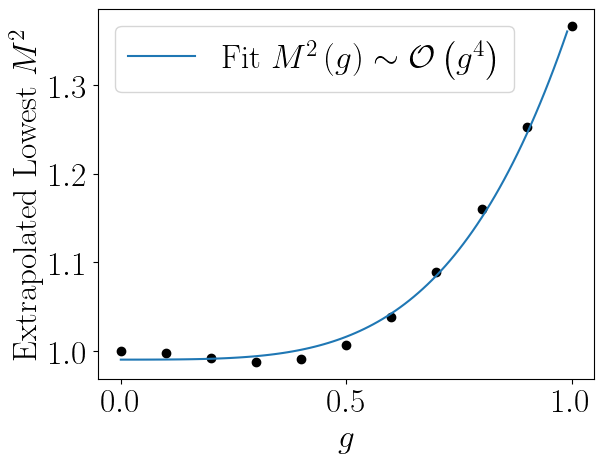

In [304]:
plt.plot(gs, ms, 'ko')
plt.ylabel(f"Extrapolated Lowest $M^2$")
plt.xlabel(f"$g$")
x_tab = np.arange(0, 1, 0.01)
plt.plot(x_tab, g_fit(x_tab, *g_fit_params[0]), label = r'Fit $M^2\left(g\right) \sim \mathcal{O}\left(g^4\right)$')
plt.legend()

### `Plot #7`: $M^2$ Extrapolated vs. $t$ in $\{|f\rangle, |fb\rangle \}$ and $\{|ff\rangle, |ffb\rangle \}$ at $g = 0.3$

In [2]:
def m2_fit(x, a, b, c):
    return a + b/x + c/(x**2)

In [7]:
plot_7_g = 0.3
ts = [1e-14, 1e-12, 1e-10, 1e-8, 1e-6, 1e-4, 1e-2, 1e0, 1]

plot_7_max_K = 20

half_integer_Ks = np.arange(1/2, plot_7_max_K, 2)
integer_Ks = np.arange(2, plot_7_max_K, 2)


f_fb_fits = []
ff_ffb_fits = []

for t in ts:
    eigenvalues_f_fb_basis = []
    eigenvalues_ff_ffb_basis = []

    #f + fb
    
    for res in half_integer_Ks:
        f_fb_basis = (
            get_sector_basis(resolution = res, n_fermions = 1, n_antifermions = 0, n_bosons = 0)#res - 1/2
            + get_sector_basis(resolution = res, n_fermions = 1, n_antifermions = 0, n_bosons = 1)#res - 1/2
        )  
        hamiltonian = renormalized_yukawa_hamiltonian(res = res, t = t, treg = 0, g = plot_7_g, mf = mf, mb = mb)
        tmp_mat = generate_matrix_hermitian(hamiltonian, f_fb_basis)
        vals = np.linalg.eigvalsh(tmp_mat)
        eigenvalues_f_fb_basis.append(min(vals))

    params = curve_fit(m2_fit, half_integer_Ks, eigenvalues_f_fb_basis)
    f_fb_fits.append(m2_fit(np.inf, *params[0]))

        

    #ff + ffb
    
    for res in integer_Ks:
        ff_ffb_basis = (
            get_sector_basis(resolution = res, n_fermions = 2, n_antifermions = 0, n_bosons = 0)
            + get_sector_basis(resolution = res, n_fermions = 2, n_antifermions = 0, n_bosons = 1)
        )  
        hamiltonian = renormalized_yukawa_hamiltonian(res = res, t = t, treg = 0, g = plot_7_g, mf = mf, mb = mb)
        tmp_mat = generate_matrix_hermitian(hamiltonian, ff_ffb_basis)
        vals = np.linalg.eigvalsh(tmp_mat)
        eigenvalues_ff_ffb_basis.append(min(vals))
    params = curve_fit(m2_fit, integer_Ks, eigenvalues_ff_ffb_basis)
    ff_ffb_fits.append(m2_fit(np.inf, *params[0]))



In [15]:
lambdas = 1/np.sqrt(np.array(ts))

In [18]:
def Lambda(t):
    return 1/np.sqrt(t)

In [21]:
Lambda(1e-6)

1000.0

In [20]:
1000000 == 1e6

True

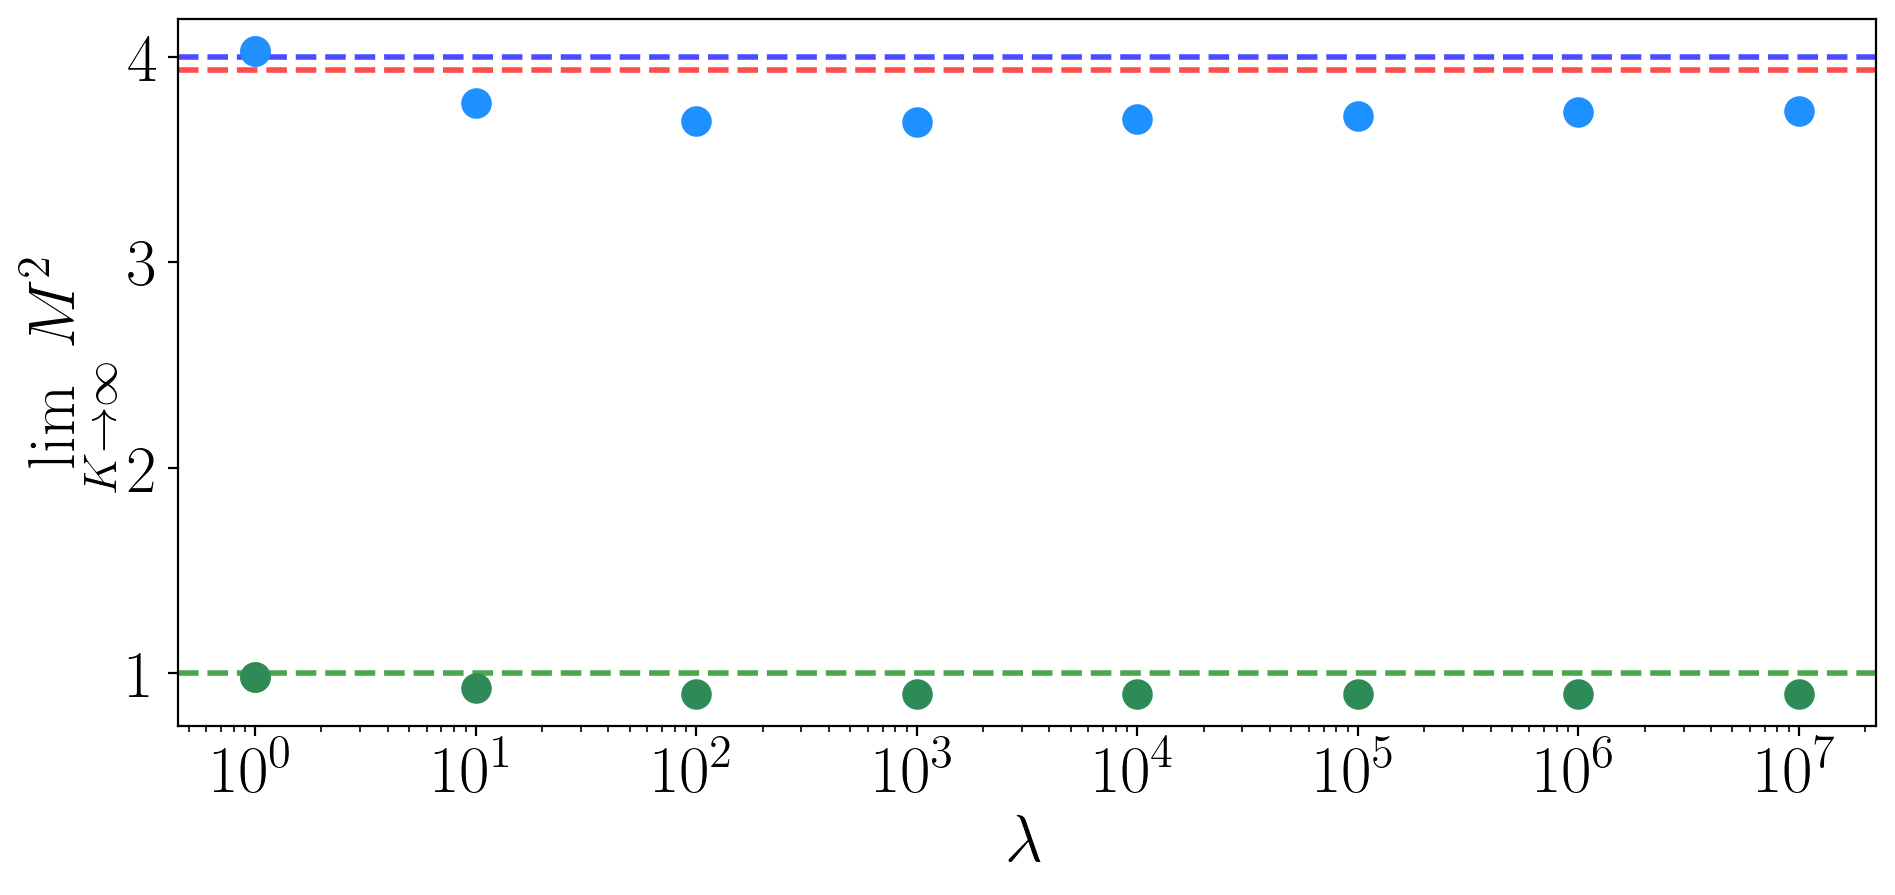

In [17]:
plt.figure(figsize=(10,5), dpi=200)
plt.axhline(y = mf**2, color = 'green', linestyle = '--', alpha = 0.7, linewidth = 2,zorder = -1)
plt.axhline(y = 4*mf**2, color = 'blue', linestyle = '--', alpha = 0.7, linewidth = 2,zorder = -1)
plt.axhline(y=min(nonrelativistic_yukawa(0.3, mf, mb)) * 2*2*mf + (2*mf)**2, color='r', alpha = 0.7,linestyle = '--', linewidth = 2, zorder = -1)
plt.scatter(lambdas, f_fb_fits, color = 'seagreen', s = 100)
plt.scatter(lambdas, ff_ffb_fits, color = 'dodgerblue', s = 100)
plt.ylabel(r"$\lim\limits_{K \rightarrow \infty} M^2$")
plt.xlabel(f"$\lambda$")
plt.xscale('log')
plt.tight_layout()
plt.savefig('../M2_vs_lambda.pdf')

Without extrapolation at $K = 18$

In [159]:
plot_7_g = 0.3
# ts = [1e-14, 1e-11, 1e-8, 1e-5, 1e-2, 1, 10]
ts = [1e-12]

In [160]:
fixed_k_fits_f_fb = []
fixed_k_fits_ff_ffb = []
K = 20

for t in ts:
    #f + fb
    

    f_fb_basis = (
        get_sector_basis(resolution = K - 1/2, n_fermions = 1, n_antifermions = 0, n_bosons = 0)
        + get_sector_basis(resolution = K - 1/2, n_fermions = 1, n_antifermions = 0, n_bosons = 1)
    )  
    hamiltonian = renormalized_yukawa_hamiltonian(res = K, t = t, treg = 0, g = plot_7_g, mf = mf, mb = mb)
    tmp_mat = generate_matrix_hermitian(hamiltonian, f_fb_basis)
    vals = np.linalg.eigvalsh(tmp_mat)
    fixed_k_fits_f_fb.append(min(vals))


        

    #ff + ffb
    
    ff_ffb_basis = (
        get_sector_basis(resolution = K, n_fermions = 2, n_antifermions = 0, n_bosons = 0)
        + get_sector_basis(resolution = K, n_fermions = 2, n_antifermions = 0, n_bosons = 1)
    )  
    hamiltonian = renormalized_yukawa_hamiltonian(res = K, t = t, treg = 0, g = plot_7_g, mf = mf, mb = mb)
    tmp_mat = generate_matrix_hermitian(hamiltonian, ff_ffb_basis)
    vals = np.linalg.eigvalsh(tmp_mat)
    fixed_k_fits_ff_ffb.append(min(vals))


free_hamiltonian = yukawa_hamiltonian(res = K, g = 0, mf = mf, mb = mb)

ground_f_fb_sector = min((np.linalg.eigvalsh(generate_matrix_hermitian(free_hamiltonian, f_fb_basis))))
ground_ff_ffb_sector = min((np.linalg.eigvalsh(generate_matrix_hermitian(free_hamiltonian, ff_ffb_basis))))
    

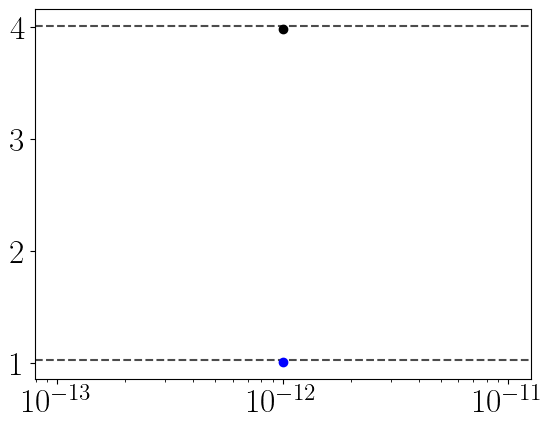

In [162]:
plt.axhline(y = ground_f_fb_sector, color = 'k', linestyle = '--', alpha = 0.7)
plt.axhline(y = ground_ff_ffb_sector, color = 'k', linestyle = '--', alpha = 0.7)

# for eigenvalue in free_eigenvalues[0]:
#     if eigenvalue < 2 * (2*mf)**2:
#         plt.axhline(y = eigenvalue, color = 'red', linestyle = '--', alpha = 0.5)

plt.plot(ts, fixed_k_fits_f_fb, 'bo')
plt.plot(ts, fixed_k_fits_ff_ffb, 'ko')
plt.xscale('log')

In [352]:
full_g = 1
K_max = 10

bare_eigenvalues = []
renormalized_eigenvalues = []
resolutions = np.arange(1,K_max,1)

for res in resolutions:

    basis = impose_baryon_number(int(res), momentum_states_partition(res), 0)
    bare_hamiltonian = yukawa_hamiltonian(
            res=int(res), g=full_g, mf=mf, mb=mb
        )
    renormalized_hamlitonian = renormalized_yukawa_hamiltonian(res = int(res), t = 1e-12, treg = 0, g = full_g, mf = mf, mb = mb)

    bare_matrix = generate_matrix_hermitian(bare_hamiltonian, basis)
    ren_matrix = generate_matrix_hermitian(renormalized_hamlitonian, basis)
    bare_vals = np.linalg.eigvalsh(bare_matrix)
    ren_vals = np.linalg.eigvalsh(ren_matrix)
    bare_eigenvalues.append(min(bare_vals))
    renormalized_eigenvalues.append(min(ren_vals))


    


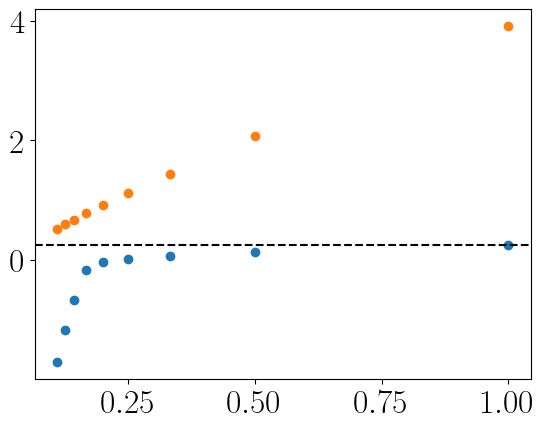

In [357]:
plt.scatter(1/resolutions, bare_eigenvalues)
plt.scatter(1/resolutions, renormalized_eigenvalues)
plt.axhline(y = mb**2, linestyle = '--', color = 'k')

In [4]:
bare_vals = []
ren_vals = []
res_vals = np.arange(2, 26, 1)

for res in res_vals:
    bare = yukawa_hamiltonian(res = res, g = 1, mf = 1, mb = 0.5)
    ren = renormalized_yukawa_hamiltonian(res = res, t = 1e-12, treg = 0, g = 1, mf = 1, mb = 0.5)
    bare_vals.append(len(bare))
    ren_vals.append(len(ren))

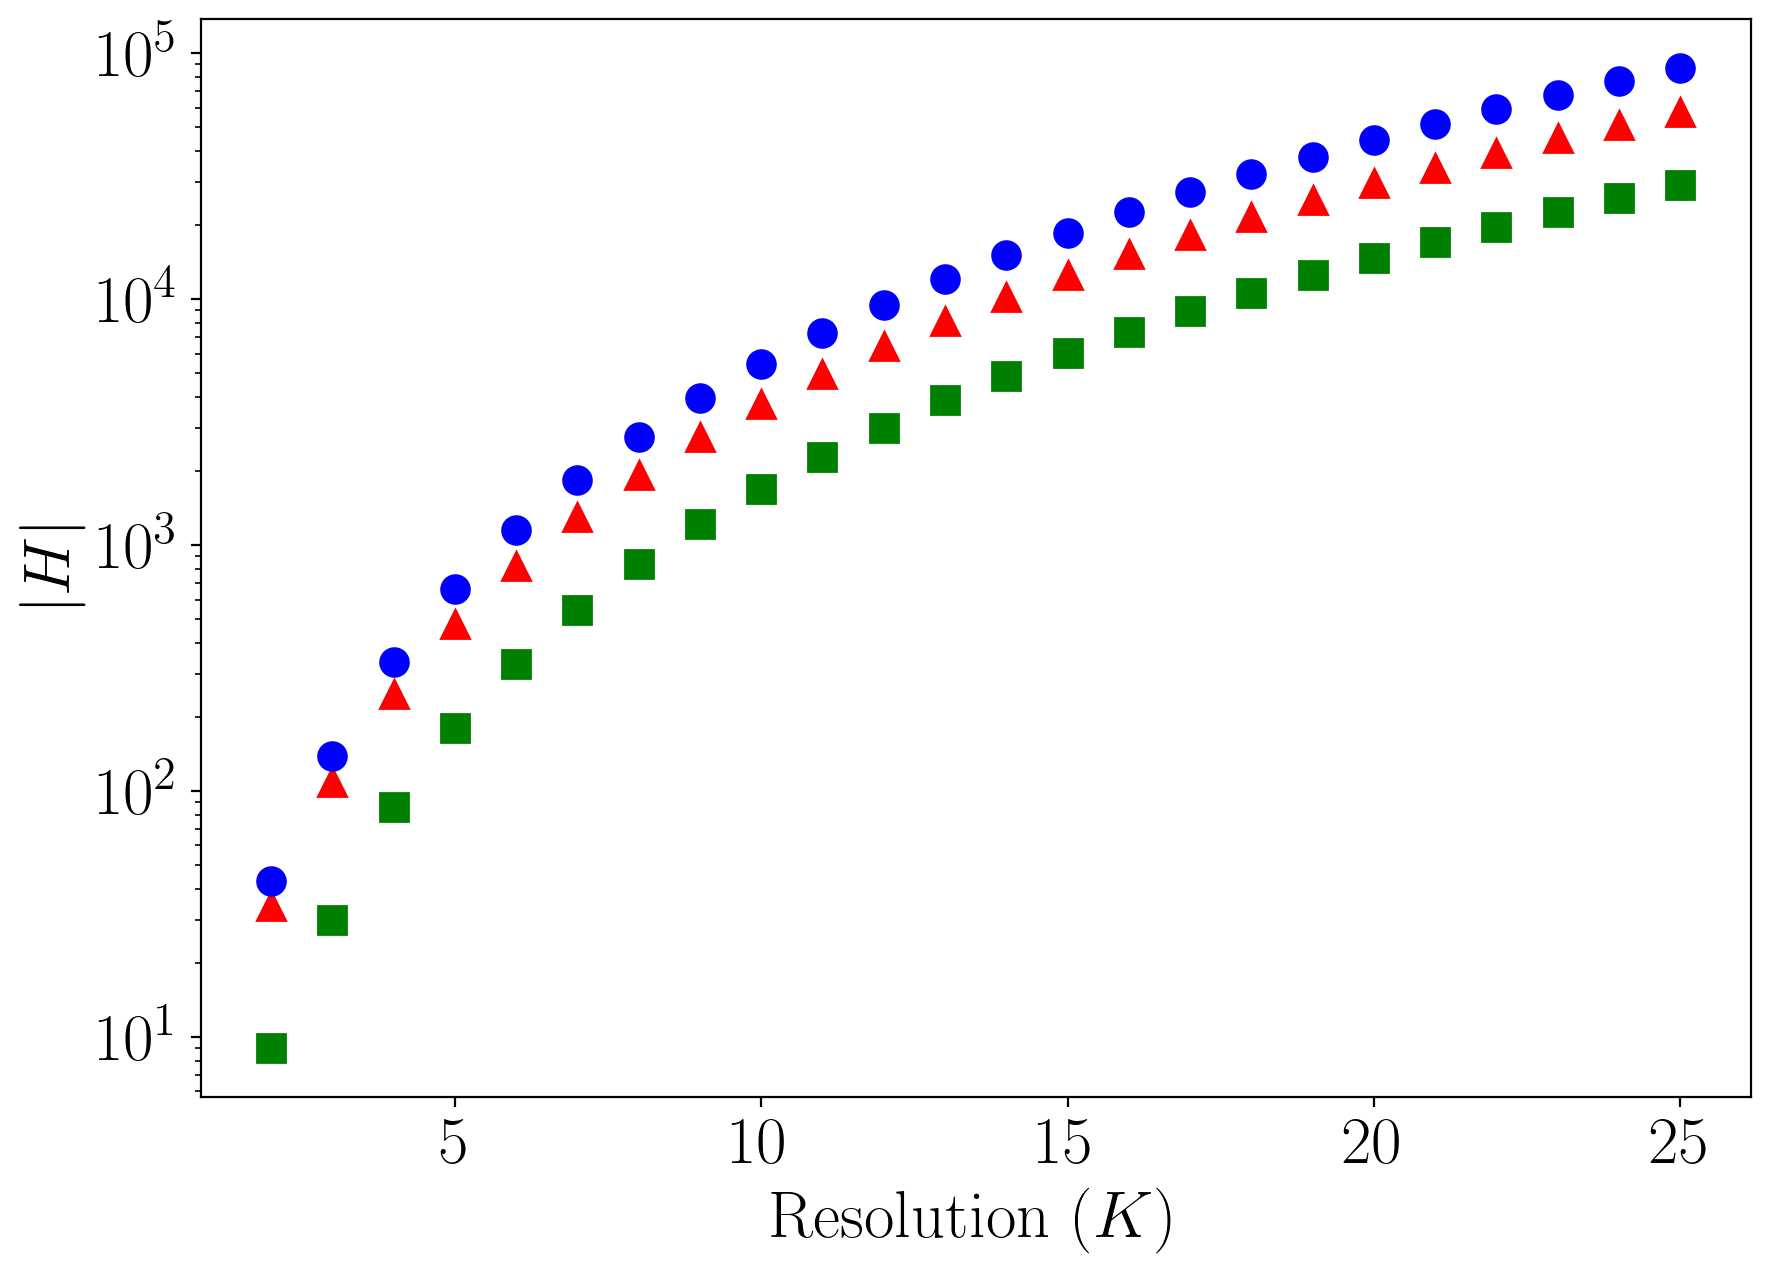

In [16]:
plt.figure(figsize = (10, 7), dpi = 200)
plt.plot(res_vals, bare_vals, 'r^', label = 'Bare', markersize = 10)
plt.plot(res_vals, ren_vals, 'bo', label = 'Renormalized', markersize = 10)
plt.plot(res_vals, np.array(ren_vals) - np.array(bare_vals), 'gs', label = 'Difference', markersize = 10)

plt.xlabel("Resolution ($K$)")
# plt.ylabel("Number of terms in Hamiltonian")
plt.ylabel(f'$|H|$')
plt.yscale('log')
# plt.xscale('log')
# plt.xticks([10, 20, 30, 40, 50])
# plt.xlim(0, 32)
# plt.legend()
plt.savefig('../n_terms.pdf')

### Fermion Loop

In [77]:
import scipy.integrate as integrate
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 24
plt.rc('text', usetex=True)
import warnings
warnings.filterwarnings('ignore')

In [78]:
m = 1
mu = 0.5
q = 1

In [79]:
def calM(x):
    return m**2 / x + mu**2 / (1 - x)

def f(x, t):
    return np.exp(-t / q**2 * (calM(x) - m**2)**2)

In [80]:
def integrand(x, t_val, treg_val):
    return 1/(x * (1 - x)) * (1 + x)**2 / ( x * (calM(x) - m**2) ) * (f(x, t_val + treg_val)**2 - f(x, treg_val)**2) 

def m_eff(t, treg):
    return np.array([m**2 + m**2 * integrate.quad(integrand, 0, 1, args = (current_t, treg))[0] for current_t in t])

In [81]:
t_tab = np.arange(0, 10, 1e-2)

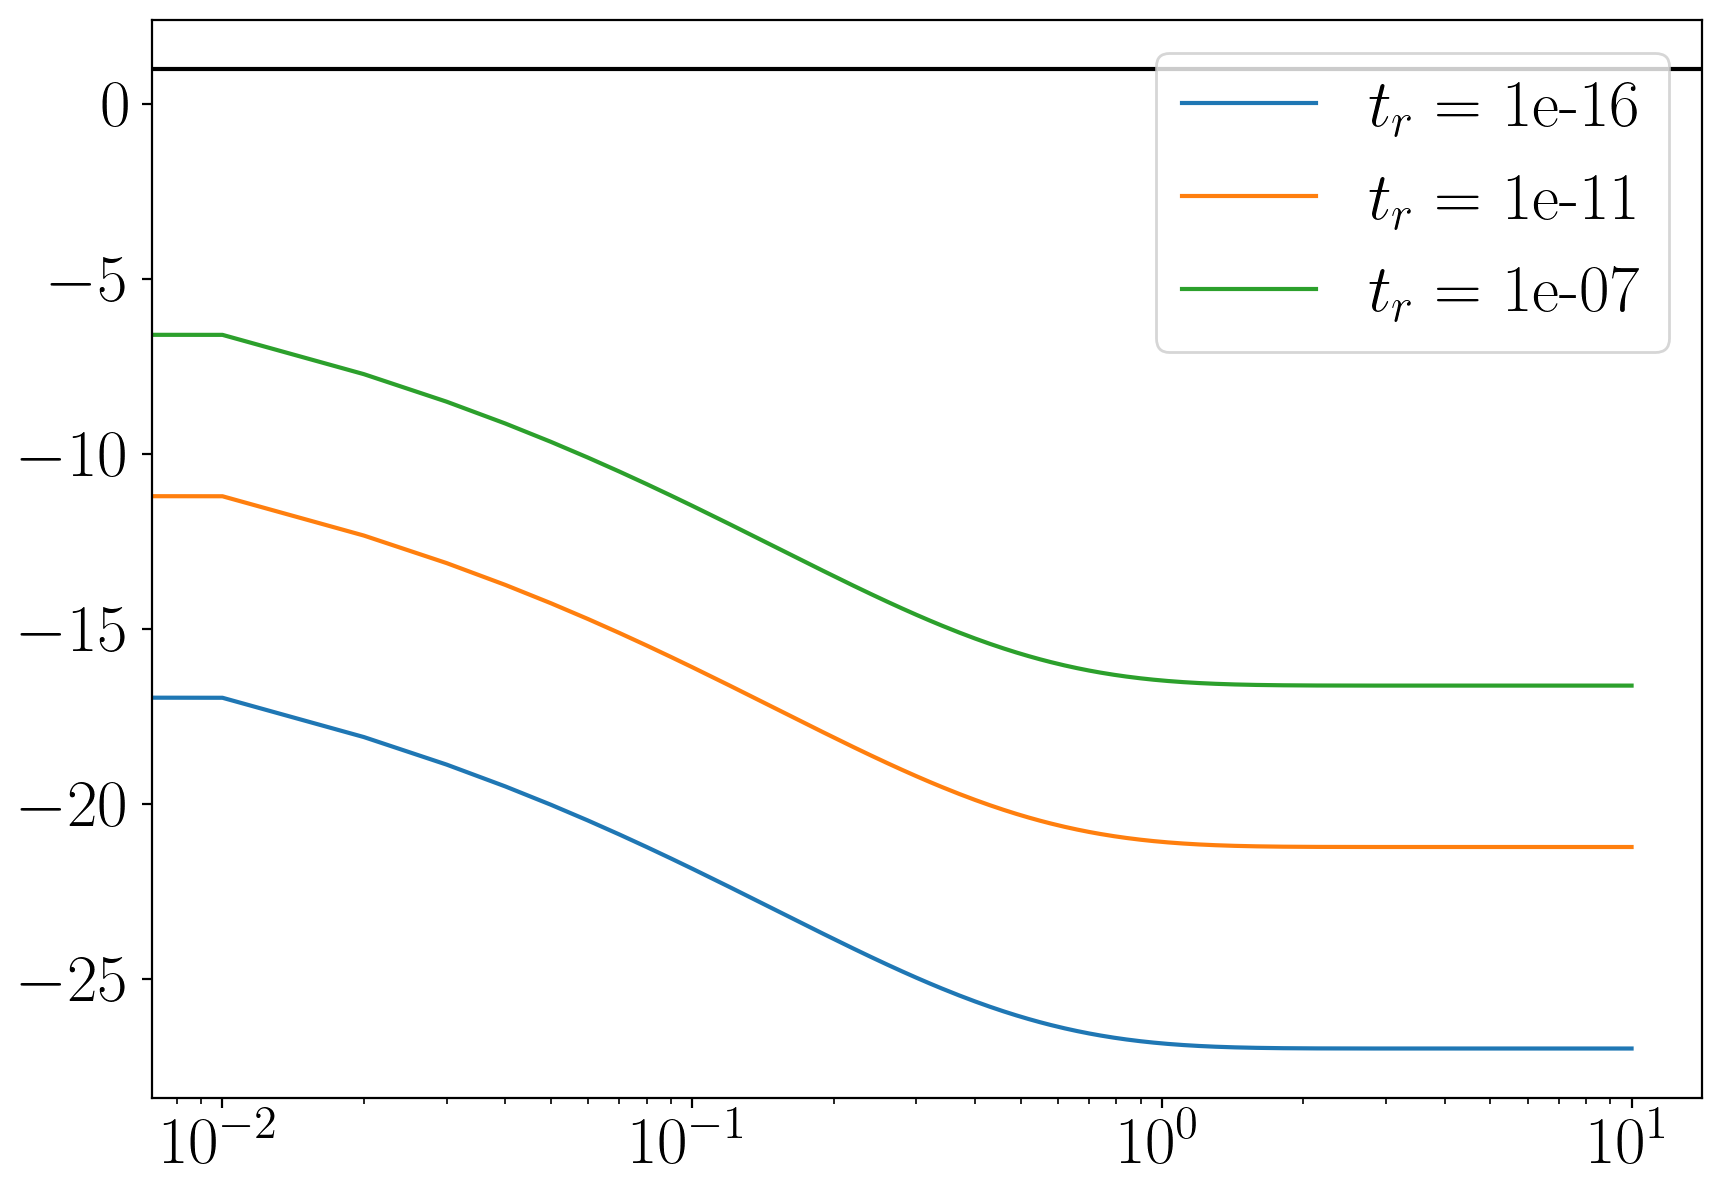

In [86]:
plt.figure(figsize = (10, 7), dpi = 200)

for regs in [1e-16, 1e-11, 1e-7]:
    plt.plot(t_tab, m_eff(t_tab, treg = regs), label = r'$t_r$ = ' + str(regs))

plt.axhline(y = m**2, color = 'k')
plt.legend()
plt.xscale('log')